# Simulation Run Log Analysis and Visualization for AWS DeepRacer

This notebook walks through how you can analyze and debug using the AWS DeepRacer Simulation logs 

```
1. Tools to find best iteration of your model
2. Visualize reward distribution on the track
  2.1 Visualize reward heatmap per episode or iteration
3. Identify hotspots on the track for your model
4. Understand probability distributions on simulated images
5. Evaluation run analysis - plot lap speed heatmap
```

## Requirements

boto3 >= 1.9.133  ; configure your aws cli and/or boto credentials file

AWS CLI: https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html

Boto Configuration: https://boto3.amazonaws.com/v1/documentation/api/latest/guide/configuration.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

In [2]:
#Shapely Library
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

In [3]:
from log_analysis import *
import cw_utils

In [4]:
# Make sure your boto version is >= '1.9.133'
cw_utils.boto3.__version__

'1.9.224'

### Download the desired log file given the simulation ID 


If you wish to bulk export the logs from Amazon Cloudwatch to Amazon S3 :: 
https://docs.aws.amazon.com/AmazonCloudWatch/latest/logs/S3ExportTasks.html

In [17]:
stream_name = 'sim-p0nhvn4dwqfg' ## CHANGE This to your simulation application ID
fname = 'logs/deepracer-%s.log' %stream_name

In [18]:
cw_utils.download_log(fname, stream_prefix=stream_name)

In [1]:
stream_name = 'rl_coach_1110_1568828096721' ## CHANGE This to your simulation application ID
fname = 'logs/%s.log' %stream_name

In [4]:
stream_name = 'models/PongDancer-8/rl_coach_1127_1570493661988.log' ## CHANGE This to your simulation application ID
fname = 'logs/%s' %stream_name

In [30]:
fname = 'logs/models/Alexandra-1/rl_coach_1115_1570187451751.log'

In [5]:
!tail -n 3 $fname


[botocore.credentials][INFO] 2019-10-07 05:06:59,176: Found credentials in environment variables.
[botocore.credentials][INFO] 2019-10-07 05:06:59,514: Found credentials in environment variables.


## Load waypoints for the track you want to run analysis on

```Tracks Available::
AWS_track                Straight_track         Oval_track
Bowtie_track             H_track                reinvent_base
London_Loop_Train        mexico                 shanghai
New_York_Track           Tokyo_Training_track   Canada_Training
```

In [5]:
waypoints = get_track_waypoints("Canada_Training")
waypoints.shape

(203, 6)

## Visualize the Track and Waypoints

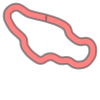

In [6]:
l_center_line = LineString(waypoints[:,0:2])
l_inner_border = LineString(waypoints[:,2:4])
l_outer_border = LineString(waypoints[:,4:6])
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))

road_poly

In [7]:
# rescale waypoints to centimeter scale

center_line = waypoints[:,0:2] *100
inner_border = waypoints[:,2:4] *100
outer_border = waypoints[:,4:6] *100

## Load the training log

In [8]:
EPISODE_PER_ITER = 50

In [9]:
#fname = 'logs/deepracer-%s.log' % stream_name
data = load_data(fname)

In [10]:
df = convert_to_pandas(data, None, EPISODE_PER_ITER)
df.tail()

,iteration,episode,steps,x,y,yaw,steer,throttle,action,reward,done,on_track,progress,closest_waypoint,track_len,timestamp
21468,18,888,2,322.71,-185.06,-0.7396,0.52,5.0,5.0,0.8152,0,True,0.8451,82,21.74,1570497179.8216302
21469,18,888,3,328.12,-189.15,-0.7028,0.09,8.0,8.0,0.9599,0,True,1.1570,82,21.74,1570497179.906693
21470,18,888,4,335.63,-194.33,-0.6553,0.52,5.0,5.0,0.7207,0,True,1.5758,83,21.74,1570497180.0047414
21471,18,888,5,345.49,-199.84,-0.5701,0.52,5.0,5.0,0.7624,0,True,2.0914,84,21.74,1570497180.0958545
21472,18,888,6,354.87,-203.86,-0.4824,0.52,5.0,5.0,0.8140,0,True,2.5510,85,21.74,1570497180.1892333


In [11]:
df['y'].min(), df['y'].max()

(-330.46999999999997, 322.92)

In [12]:
df['reward'].min(), df['reward'].max()

(0.0, 4.672)

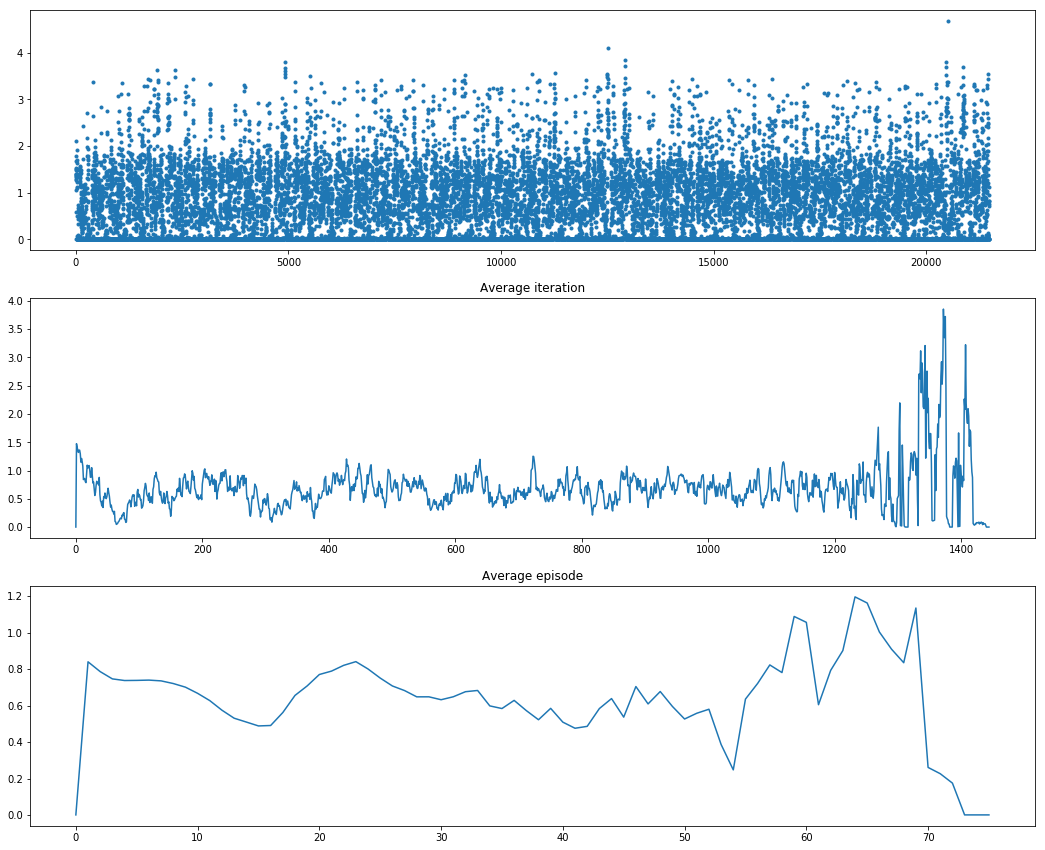

In [14]:
plot_param_charts(df)

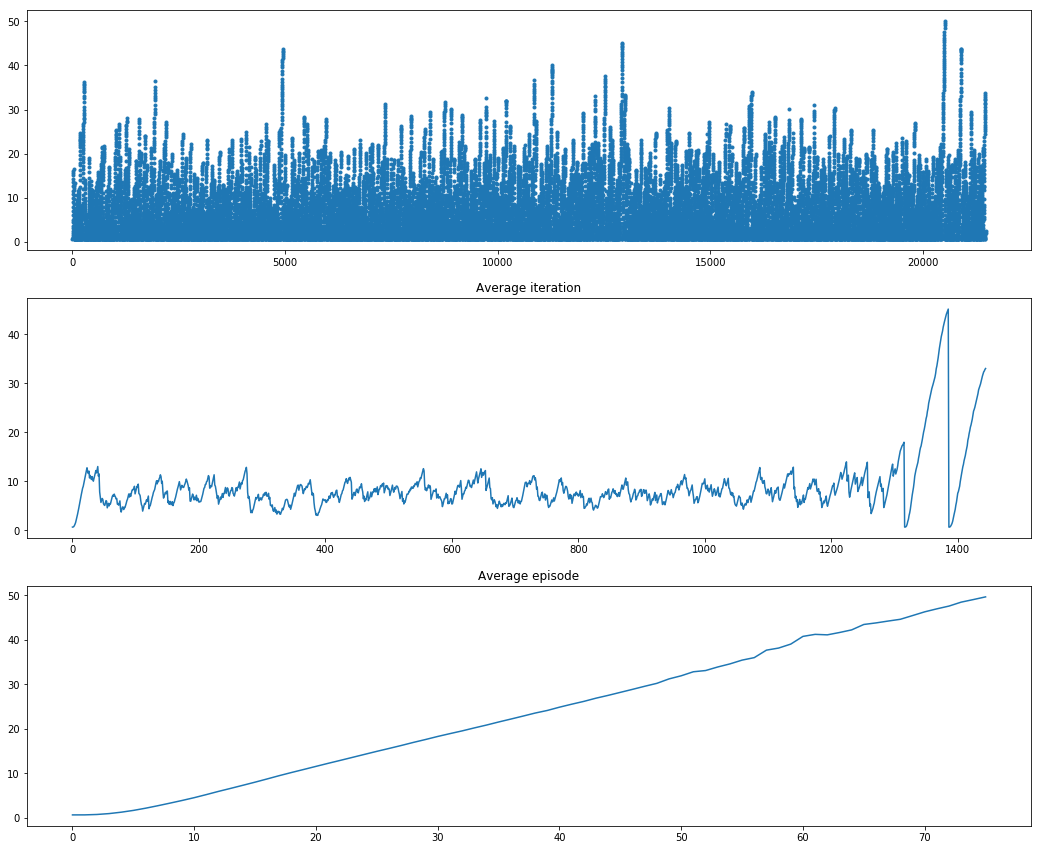

In [15]:
plot_param_charts(df, 'progress')

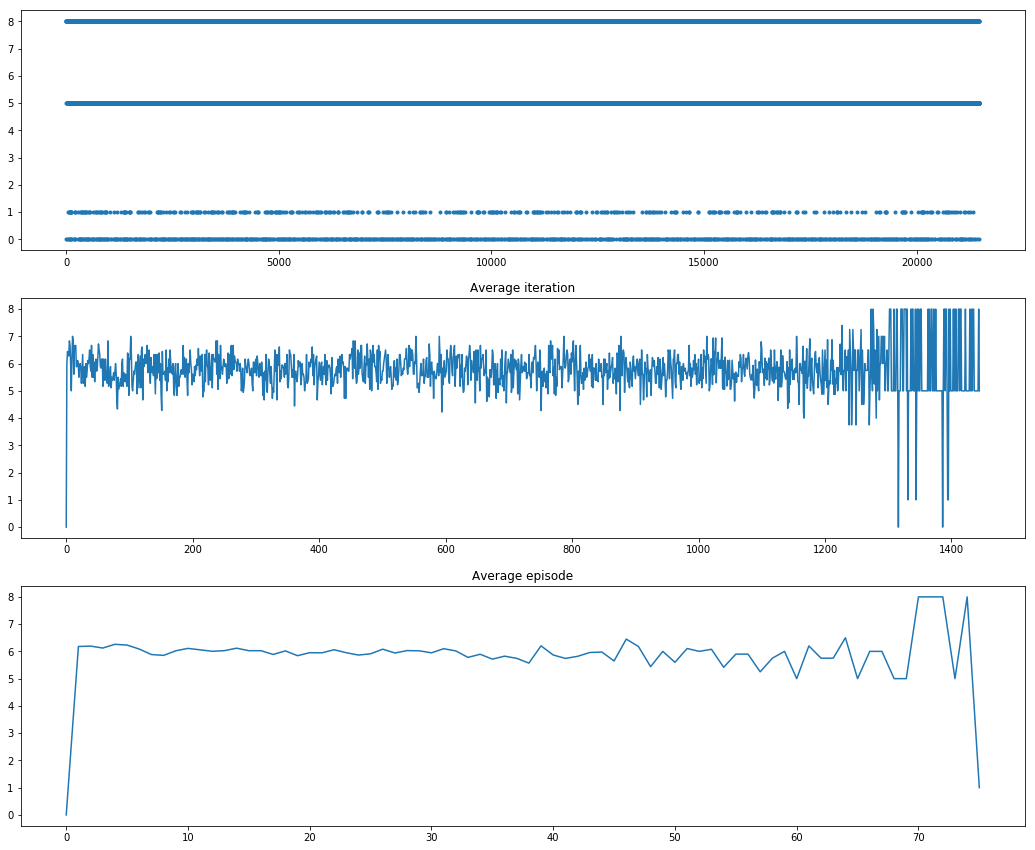

In [16]:
plot_param_charts(df, 'throttle')

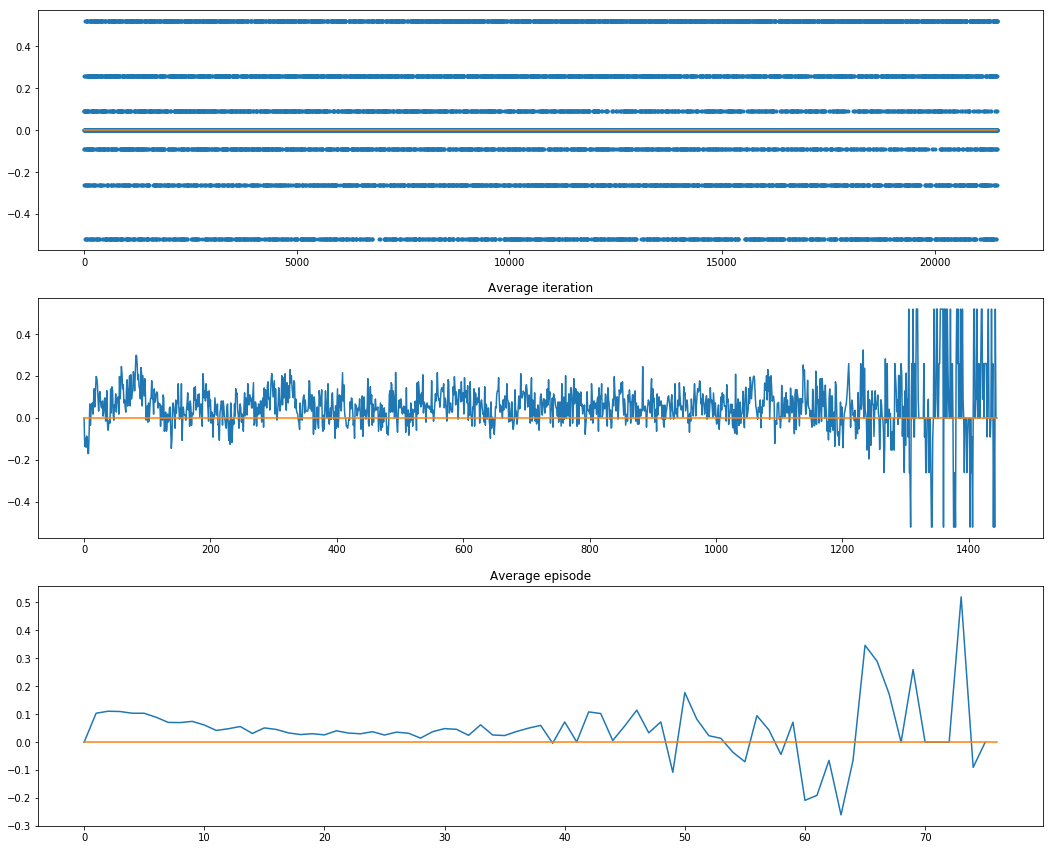

In [17]:
plot_param_charts(df, 'steer', 0.0)

8.0


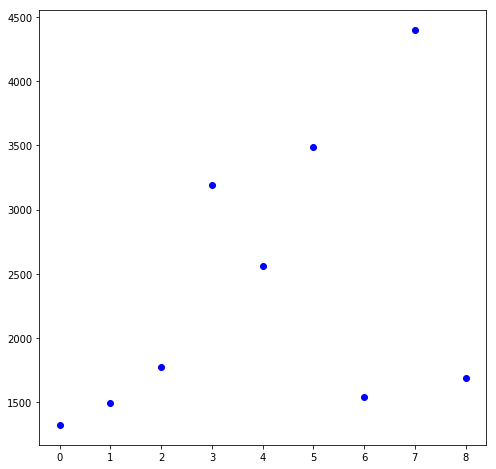

In [18]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
print(max(df['action']))
for a in range(0, 1+int(max(df['action']))):
    df_slice = df[df['action'] == a]
    ax.plot(a, len(df_slice), 'bo')

In [19]:
!cat 'logs/models/PongDancer-8/model_metadata.json'

{
    "action_space": [
        {
            "steering_angle": 0,
            "speed": 1,
            "index": 0
        },

        {
            "steering_angle": -30,
            "speed": 5,
            "index": 1
        },
        {
            "steering_angle": -15,
            "speed": 5,
            "index": 2
        },
        {
            "steering_angle": 0,
            "speed": 5,
            "index": 3
        },
        {
            "steering_angle": 15,
            "speed": 5,
            "index": 4
        },
        {
            "steering_angle": 30,
            "speed": 5,
            "index": 5
        },

        {
            "steering_angle": -5,
            "speed": 8,
            "index": 6
        },
        {
            "steering_angle": 0,
            "speed": 8,
            "index": 7
        },
        {
            "steering_angle": 5,
            "speed": 8,
            "index": 8
        }
    ]
}


## Plot rewards per Iteration

This graph is useful to understand the mean reward and standard deviation within each episode 

Number of episodes =  888


/home/gbs/.local/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/gbs/.local/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Text(0.5, 0, 'Iteration')

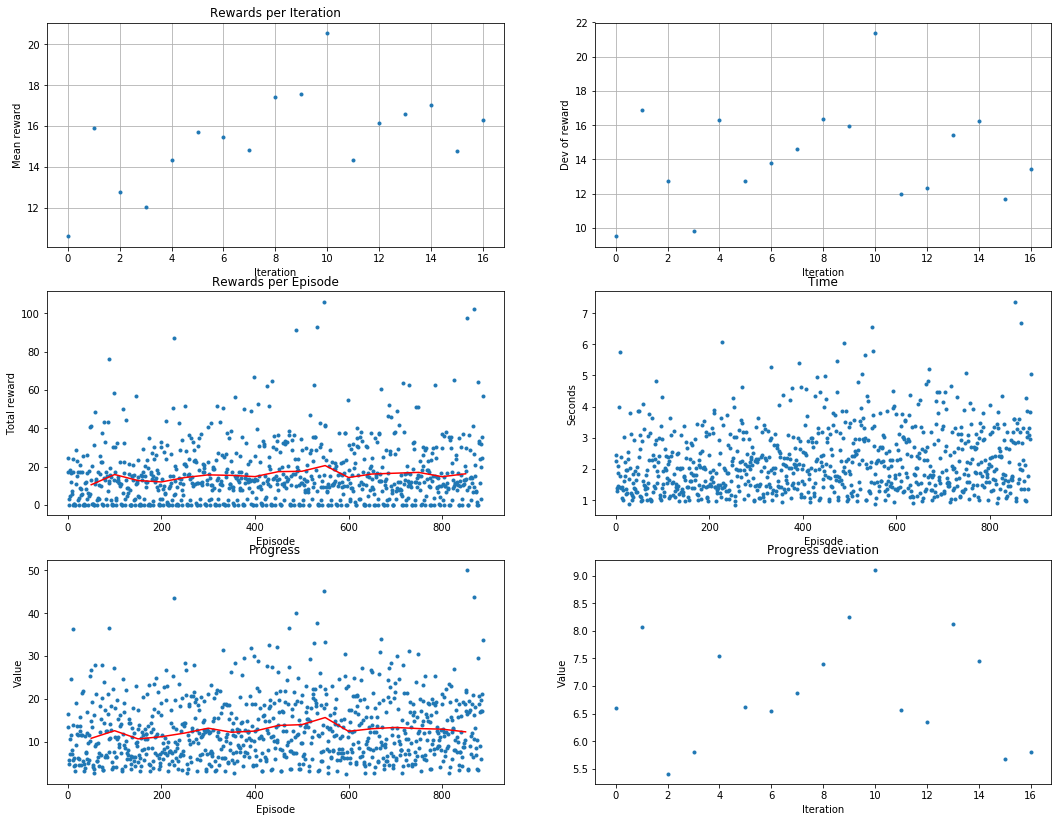

In [13]:
REWARD_THRESHOLD = 200

# reward graph per episode
min_episodes = np.min(df['episode'])
max_episodes = np.max(df['episode'])
print('Number of episodes = ', max_episodes)

total_reward_per_episode = list()
for epi in range(min_episodes, max_episodes):
    df_slice = df[df['episode'] == epi]
    total_reward_per_episode.append(np.sum(df_slice['reward']))

average_reward_per_iteration = list()
deviation_reward_per_iteration = list()
buffer_rew = list()
for val in total_reward_per_episode:
    buffer_rew.append(val)
    if len(buffer_rew) == EPISODE_PER_ITER:
        average_reward_per_iteration.append(np.mean(buffer_rew))
        deviation_reward_per_iteration.append(np.std(buffer_rew))
        # reset
        buffer_rew = list()
        
epi_progress = list()
for epi in range(min_episodes, max_episodes):
    df_slice = df[df['episode'] == epi]
    epi_progress.append(max(df_slice['progress']))
        
average_progress_per_iteration = list()
deviation_progress_per_iteration = list()
buffer_rew = list()
for val in epi_progress:
    buffer_rew.append(val)
    if len(buffer_rew) == EPISODE_PER_ITER:
        average_progress_per_iteration.append(np.mean(buffer_rew))
        deviation_progress_per_iteration.append(np.std(buffer_rew))
        # reset
        buffer_rew = list()

part_times = list()
for epi in range(min_episodes, max_episodes):
    df_slice = df[df['episode'] == epi]
    df_slice.loc[:, 'timestamp'] = df_slice['timestamp'].astype('float')
    #part_times.append((max(df_slice['timestamp']) - min(df_slice['timestamp'])) / max(df_slice['progress']))
    part_times.append(max(df_slice['timestamp']) - min(df_slice['timestamp']))

fig = plt.figure(figsize=(18, 14))
ax = fig.add_subplot(321)
ax.plot(np.arange(len(average_reward_per_iteration)), average_reward_per_iteration, '.')
ax.set_title('Rewards per Iteration')
ax.set_ylabel('Mean reward')
ax.set_xlabel('Iteration')
for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD :
        ax.plot(rr, average_reward_per_iteration[rr], 'r.')

plt.grid(True)

ax = fig.add_subplot(322)
ax.plot(np.arange(len(deviation_reward_per_iteration)), deviation_reward_per_iteration, '.')

ax.set_ylabel('Dev of reward')
ax.set_xlabel('Iteration')
plt.grid(True)
for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD:
        ax.plot(rr, deviation_reward_per_iteration[rr], 'r.')


ax = fig.add_subplot(323)
ax.plot(np.arange(len(total_reward_per_episode)), total_reward_per_episode, '.')
ax.set_ylabel('Total reward')
ax.set_xlabel('Episode')

ax = fig.add_subplot(323)
ax.plot(np.arange(len(average_reward_per_iteration))*EPISODE_PER_ITER + EPISODE_PER_ITER, average_reward_per_iteration, 'r')
ax.set_title('Rewards per Episode')

ax = fig.add_subplot(324)
ax.plot(np.arange(len(part_times)), part_times, '.')
ax.set_title('Time')
ax.set_ylabel('Seconds')
ax.set_xlabel('Episode')
for rr in range(len(epi_progress)):
    if epi_progress[rr] > 90.0:
        ax.plot(rr, part_times[rr], 'r.')

ax = fig.add_subplot(325)
ax.plot(np.arange(len(epi_progress)), epi_progress, '.')
ax.set_title('Progress')
ax.set_ylabel('Value')
ax.set_xlabel('Episode')
ax = fig.add_subplot(325)
ax.plot(np.arange(len(average_progress_per_iteration))*EPISODE_PER_ITER + EPISODE_PER_ITER, average_progress_per_iteration, 'r')
for rr in range(len(epi_progress)):
    if epi_progress[rr] > 90.0:
        ax.plot(rr, epi_progress[rr], 'r.')

ax = fig.add_subplot(326)
ax.plot(np.arange(len(deviation_progress_per_iteration)), deviation_progress_per_iteration, '.')
ax.set_title('Progress deviation')
ax.set_ylabel('Value')
ax.set_xlabel('Iteration')

## Analyze the reward distribution for your reward function

In [14]:
# add y_offset to bring everything to the positive axis

y_offset = int(df['y'].min())
if y_offset > 0: # if positive, just keep it the same
    y_offset = 0
y_offset = abs(y_offset)

inner_border[:,1] = inner_border[:,1] + y_offset
center_line[:,1] = center_line[:,1] + y_offset
outer_border[:,1] = outer_border[:,1] + y_offset

# Create info
info_set = create_info_set(inner_border=inner_border, center_line=center_line, outer_border=outer_border)

In [15]:
#NOTE: For the Tokyo Shanghai tracks use this dimentions
# 700, 1000 / 1200, 2100
#global_track_size = (1200, 2100)
global_track_size = (700, 1000)

In [16]:
# Normalize rewards
df_log = df.copy()
df_log['reward'] = np.log(np.array(df_log['reward']) + 1.0)

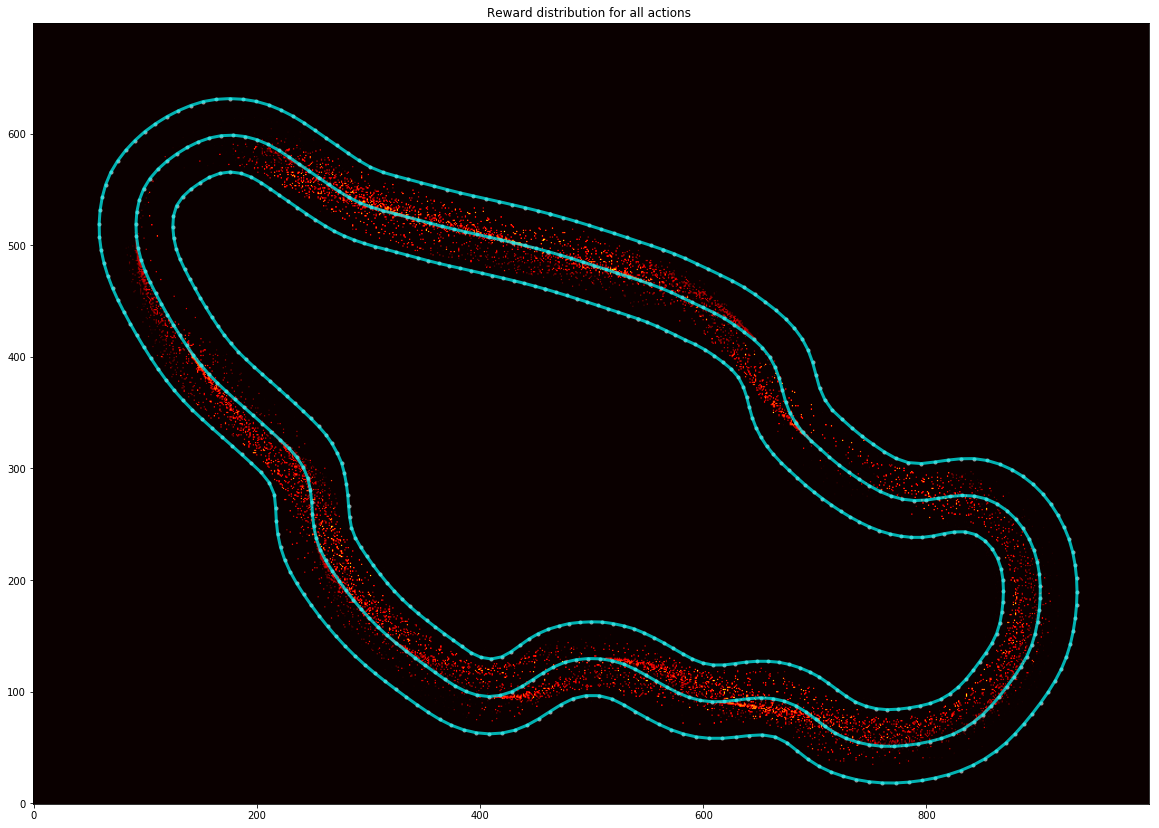

In [17]:
track = plot_track(df_log, info_set, track_size=global_track_size, x_offset=0, y_offset=y_offset, viewsize=20)
plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', interpolation='bilinear', origin="lower") 

### Speed on track

Maps speed on track like rewards

In [18]:
max(df['iteration'])

18

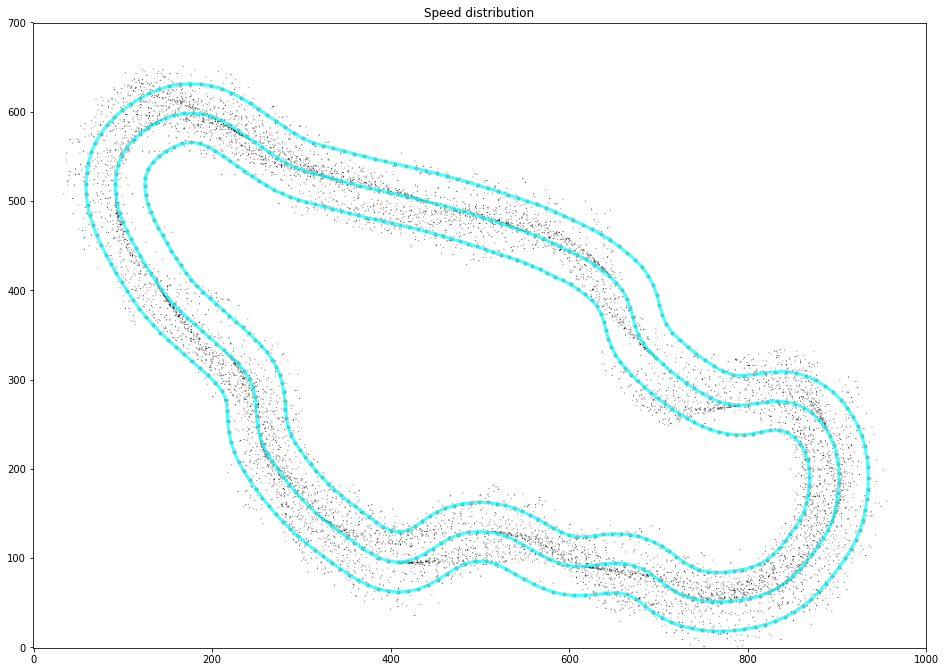

In [19]:
#NOTE: For the Tokyo Shanghai tracks use this dimentions
iteration_id = 10
track = plot_track(df[df['iteration'] >= iteration_id], info_set, track_size=global_track_size, x_offset=0, y_offset=y_offset, details=('throttle', 8.0))
plt.title("Speed distribution")
im = plt.imshow(track, cmap='binary', interpolation='bilinear', origin="lower")

### Steer on track

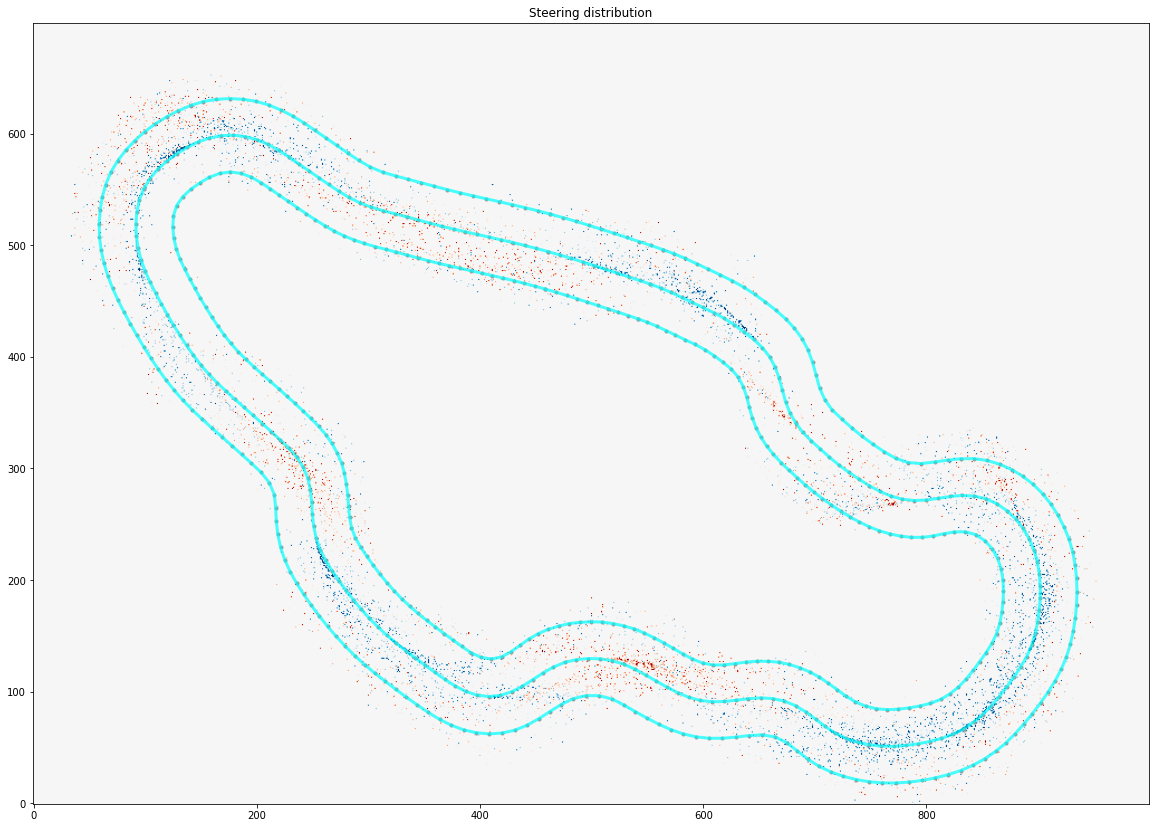

In [20]:
track = plot_track(df, info_set, track_size=global_track_size, x_offset=0, y_offset=y_offset, details=('steer', 0.5), viewsize=20)
plt.title("Steering distribution")
im = plt.imshow(track, cmap='RdBu', interpolation='bilinear', origin="lower")

### Path taken for top reward iterations

NOTE: in a single episode, the car can go around multiple laps, the episode is terminated when car completes 1000 steps

[548, 867, 853, 533]


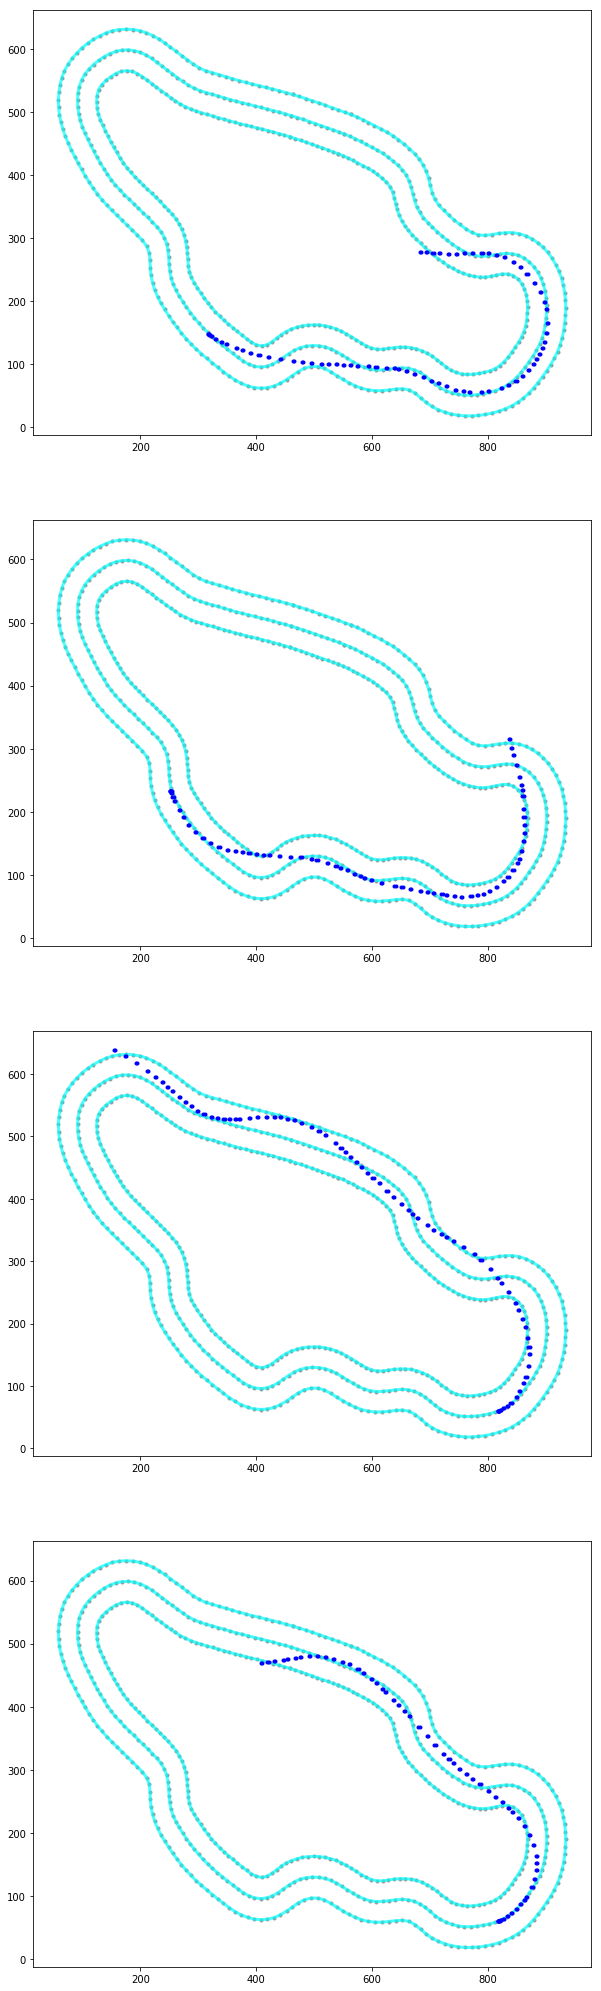

In [21]:
action_map, episode_map, sorted_idx = episode_parser(data)   
print(sorted_idx[:4])
fig = plot_top_laps(info_set, sorted_idx[:], action_map, episode_map, 4, offset=(0, y_offset))

# Speed on episode

In [22]:
print(max(df['episode']))
set(df[df['progress']>80]['episode'])

888


set()

Progress 7.5743
8.6013


Text(0.5, 0, 'Value')

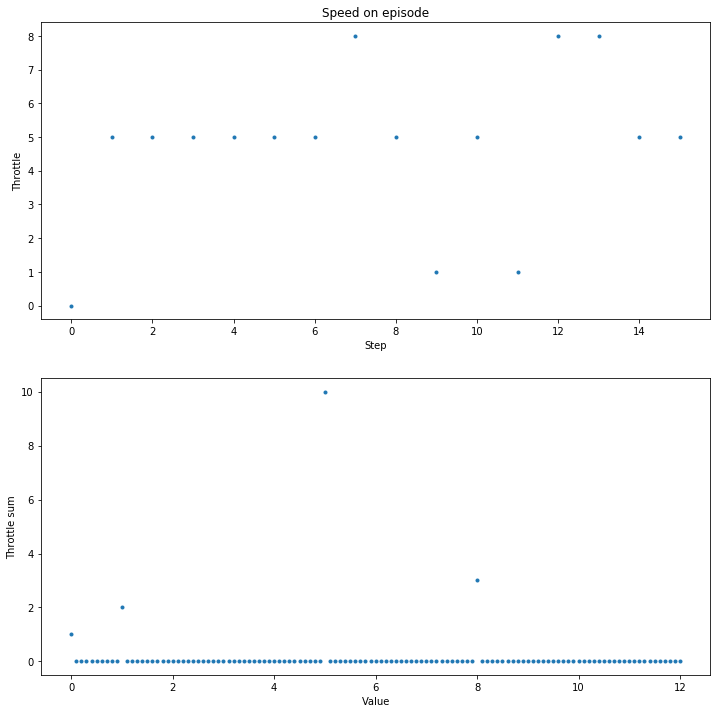

In [121]:
epi_id = 38
sp_slice = df[df['episode'] == epi_id]
print('Progress',max(sp_slice['progress']))
print(np.sum(sp_slice['reward']))
sp_slice = sp_slice['throttle']
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(211)
ax.plot(np.arange(len(sp_slice)), sp_slice, '.')
ax.set_title('Speed on episode')
ax.set_ylabel('Throttle')
ax.set_xlabel('Step')

ax = fig.add_subplot(212)
ax.plot([x/10.0 for x in range(0,121)], [ len(sp_slice[sp_slice==x/10.0]) for x in range(0,121)], '.')
ax.set_ylabel('Throttle sum')
ax.set_xlabel('Value')

### Path taken in a particular episode

In [122]:
epi_id

38

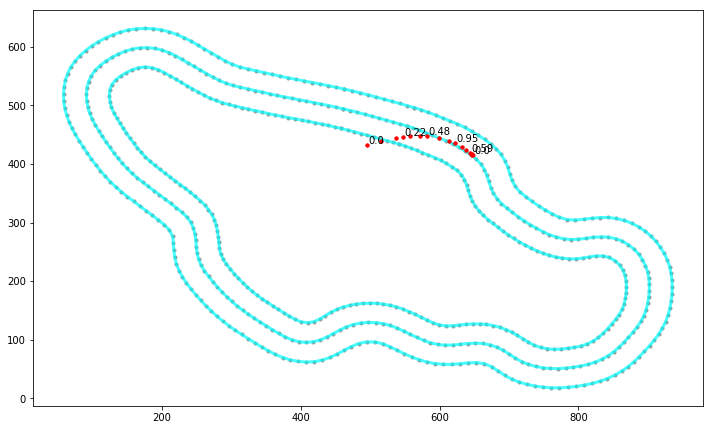

In [123]:
plot_episode_run(df, info_set, E=epi_id, y_offset=y_offset, note='reward', split=3) # arbitrary episode

### Test reward function

In [26]:
import vettel

In [27]:
df_n = df.copy()
params = df_n.rename(columns={'steer':'steering_angle', 'throttle':'speed', 'on_track':'all_wheels_on_track'})
for i in range(0, len(df_n['reward'])):
    df_n.loc[i, 'reward'] = vettel.reward_function(params.iloc[i, :])

In [111]:
epi_id = 12

95.42989935202137


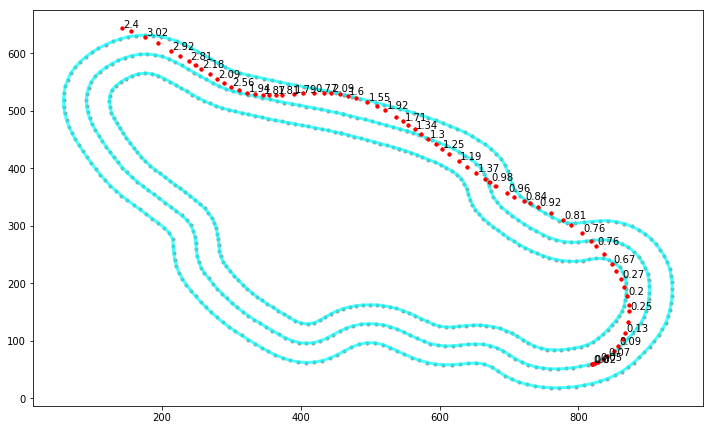

In [29]:
# tested
print(df_n[df_n['episode'] == epi_id]['reward'].sum())
plot_episode_run(df_n, info_set, E=epi_id, y_offset=y_offset, note='reward', split=2)

97.59710000000003


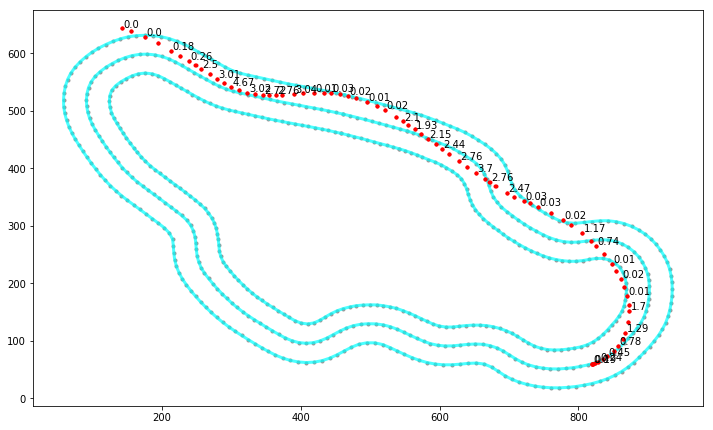

In [31]:
# original
print(df[df['episode'] == epi_id]['reward'].sum())
plot_episode_run(df, info_set, E=epi_id, y_offset=y_offset, note='reward', split=2)

### Best / worst rewarded runs

In [87]:
# get only 1 entry for each episode
len_epis = len(set(df['episode']))
df_ext = pd.DataFrame({'episode':np.arange(len_epis), 'reward':np.zeros(len_epis), 'progress':np.zeros(len_epis), 'bwratio':np.zeros(len_epis)})
for i in range(0, len_epis):
    df_slice = df[df['episode'] == i]
    df_ext.loc[i, 'episode'] = i
    df_ext.loc[i, 'reward'] = np.sum(df_slice['reward'])
    df_ext.loc[i, 'progress'] = max(df_slice['progress'])
    df_ext.loc[i, 'bwratio'] = df_ext.loc[i, 'reward'] / (df_ext.loc[i, 'progress'] + 1.0)

In [115]:
print(min(df_ext['bwratio']), max(df_ext['bwratio']))
matched = df_ext[df_ext['bwratio'] > 1.0]
matched = matched[matched['bwratio'] < 1.01]
len(matched['episode'])

0.0017511345892859756 2.3985768997559065


8

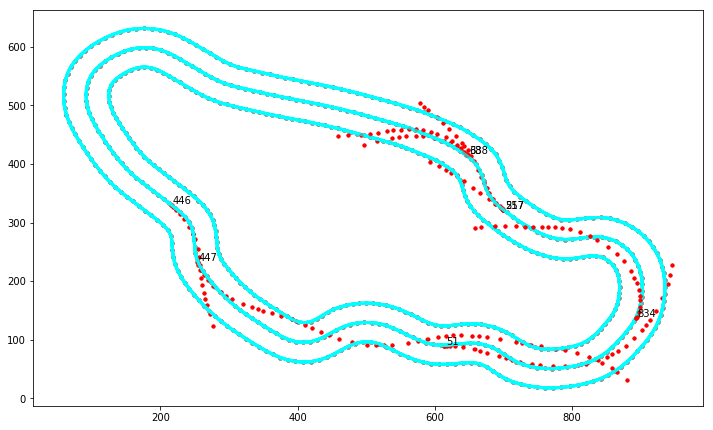

In [116]:
for i in matched['episode']:
    plot_episode_run(df, info_set, E=i, y_offset=y_offset, note='episode', split=3000)

In [117]:
matched

,episode,reward,progress,bwratio
38,38,8.6013,7.5743,1.003149
51,51,20.3506,19.3504,1.000010
217,217,8.6626,7.5770,1.009980
446,446,11.0646,9.9591,1.009627
447,447,33.1220,32.0073,1.003475
557,557,11.1296,10.1170,1.001133
638,638,10.5426,9.4710,1.006838
834,834,16.9436,15.9289,1.000868


### Path taken in a particular Iteration

In [61]:
max(df['iteration'])

48

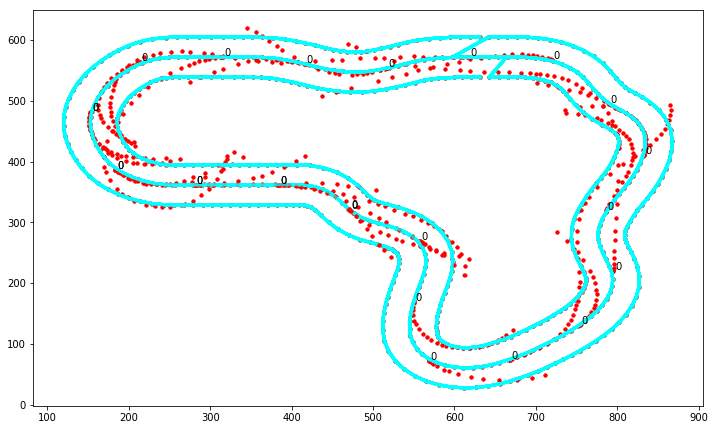

In [62]:
iteration_id = 2

for i in range((iteration_id-1)*EPISODE_PER_ITER, (iteration_id)*EPISODE_PER_ITER):
    plot_episode_run(df, info_set, E=i, y_offset=y_offset)

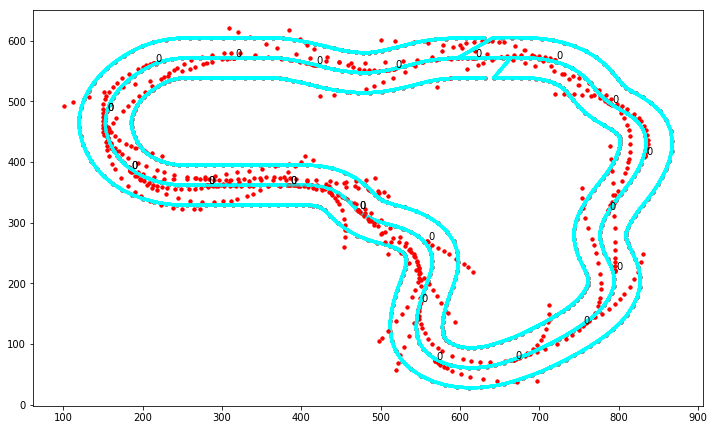

In [63]:
iteration_id = 38
for i in range((iteration_id-1)*EPISODE_PER_ITER, (iteration_id)*EPISODE_PER_ITER):
    plot_episode_run(df, info_set, E=i, y_offset=y_offset)

## Simulation Image Analysis - Probability distribution on decisions (actions)

is the model making decisions that are "too close" or is it confident for the laps it finishes. if the top and second best decisions are far apart, the model must likely be making more confident decisions 

In [25]:
import glob
img_path = "simulation_episode/"
all_files = sorted(glob.glob(img_path + '/*.png'))

In [26]:
!grep "S3 bucket" $fname
!grep "S3 prefix" $fname

S3 bucket: aws-deepracer-e203f527-c72e-48f9-b8f7-67d777a22943
S3 prefix: DeepRacer-SageMaker-RoboMaker-comm-209028685534-20190418002522-0bf01f4a-8136-493d-b3bb-98e04b2ad383


#### Download all the checkpoints (provided as an example).  
We recommend downloading only the ones you are interested in


In [ ]:
##!aws s3 sync s3://$s3_bucket/$s3_prefix/model/ intermediate_checkpoint/ --exclude "*" --include "*model_*"

In [27]:
## For this example lets download all models in interation in the 30s

## NOTE: Copy the variables from the output of the grep command
s3_bucket = ''
s3_prefix = ''
!aws s3 sync s3://$s3_bucket/$s3_prefix/model/ intermediate_checkpoint/ --exclude "*" --include "*model_3*"

In [5]:
import tensorflow as tf
import numpy as np
from tensorflow.python.platform import gfile
from PIL import Image

GRAPH_PB_PATH = 'intermediate_checkpoint/'

def load_session(pb_path):
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, 
                                    log_device_placement=True))
    print("load graph:", pb_path)
    with gfile.FastGFile(pb_path,'rb') as f:
        graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
    graph_nodes=[n for n in graph_def.node]
    names = []
    for t in graph_nodes:
        names.append(t.name)

    x = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/observation/observation:0')
    y = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    
    return sess, x, y

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [30]:
!ls $GRAPH_PB_PATH

model_30.pb
model_36.pb
worker_0.simple_rl_graph.main_level.main_level.agent_0.csv


In [31]:
model_inference = []
iterations = [30, 36]

for ii in iterations:
    model, obs, model_out = load_session(GRAPH_PB_PATH + 'model_%s.pb' % ii)
    arr = []
    for f in all_files[:]:
        img = Image.open(f)
        img_arr = np.array(img)
        img_arr = rgb2gray(img_arr)
        img_arr = np.expand_dims(img_arr, axis=2)
        current_state = {"observation": img_arr} #(1, 120, 160, 1)
        y_output = model.run(model_out, feed_dict={obs:[img_arr]})[0]
        arr.append (y_output)
        
    model_inference.append(arr)
    model.close()
    tf.reset_default_graph()

load graph: intermediate_checkpoint/model_30.pb
Instructions for updating:
Use tf.gfile.GFile.
load graph: intermediate_checkpoint/model_36.pb


(array([180., 130., 119.,  87.,  95.,  77.,  68.,  65.,  46.,  50.]),
 array([3.3897161e-04, 9.8504558e-02, 1.9667014e-01, 2.9483572e-01,
        3.9300132e-01, 4.9116689e-01, 5.8933246e-01, 6.8749803e-01,
        7.8566366e-01, 8.8382924e-01, 9.8199481e-01], dtype=float32),
 <a list of 10 Patch objects>)

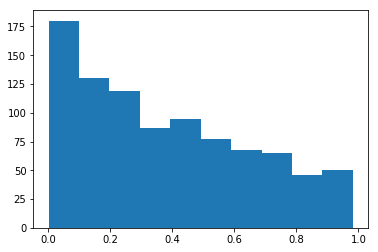

In [32]:
prob_diff = []

for mi in model_inference[0]:
    max1, max2 = mi.argsort()[-2:][::-1]
    prob_diff.append(mi[max1] - mi[max2])
plt.hist(prob_diff)

(array([124., 115.,  76.,  74.,  86.,  58.,  68.,  74.,  83., 159.]),
 array([7.3242188e-04, 1.0054918e-01, 2.0036593e-01, 3.0018267e-01,
        3.9999944e-01, 4.9981618e-01, 5.9963292e-01, 6.9944966e-01,
        7.9926646e-01, 8.9908320e-01, 9.9889994e-01], dtype=float32),
 <a list of 10 Patch objects>)

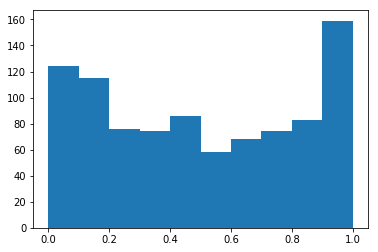

In [33]:
prob_diff = []

for mi in model_inference[1]:
    max1, max2 = mi.argsort()[-2:][::-1]
    prob_diff.append(mi[max1] - mi[max2])
plt.hist(prob_diff)

model 36 appears to have a better seperation in probabability, hence may work better in sim2real experiments

# Model CSV Analysis


Download the model from the console AWS DeepRacer > Reinforcement learning > $Training Job Name$ > Download Model


In [26]:
fname = 'intermediate_checkpoint/worker_2ms_stage3.csv'
df_csv = pd.read_csv(fname) 

In [27]:
df_csv.columns

Index(['Episode #', 'Training Iter', 'In Heatup', 'ER #Transitions',
       'ER #Episodes', 'Episode Length', 'Total steps', 'Epsilon',
       'Shaped Training Reward', 'Training Reward', 'Update Target Network',
       'Wall-Clock Time', 'Evaluation Reward', 'Shaped Evaluation Reward',
       'Success Rate', 'Loss/Mean', 'Loss/Stdev', 'Loss/Max', 'Loss/Min',
       'Learning Rate/Mean', 'Learning Rate/Stdev', 'Learning Rate/Max',
       'Learning Rate/Min', 'Grads (unclipped)/Mean',
       'Grads (unclipped)/Stdev', 'Grads (unclipped)/Max',
       'Grads (unclipped)/Min', 'Discounted Return/Mean',
       'Discounted Return/Stdev', 'Discounted Return/Max',
       'Discounted Return/Min', 'Entropy/Mean', 'Entropy/Stdev', 'Entropy/Max',
       'Entropy/Min', 'Advantages/Mean', 'Advantages/Stdev', 'Advantages/Max',
       'Advantages/Min', 'Values/Mean', 'Values/Stdev', 'Values/Max',
       'Values/Min', 'Value Loss/Mean', 'Value Loss/Stdev', 'Value Loss/Max',
       'Value Loss/Min', 'Po

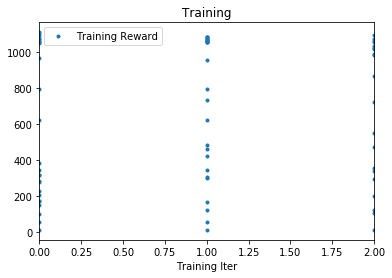

In [28]:
title = "Training"
df_csv.plot(x='Training Iter', y='Training Reward', style='.', 
        title=title)

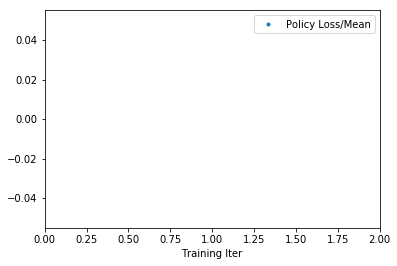

In [32]:
df_csv.plot(x='Training Iter', y='Policy Loss/Mean', style='.')

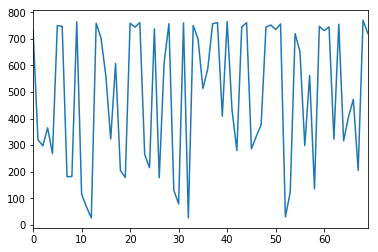

In [29]:
df_csv['Episode Length'].plot()

## Evaluation Run Analyis

Debug your evaluation runs or analyze the laps

In [39]:
eval_sim = 'sim-r8sdf488643w'
eval_fname = 'deepracer-eval-%s.log' % eval_sim

In [40]:
cw_utils.download_log(eval_fname, stream_prefix=eval_sim)

In [41]:
!head $eval_fname

RoboMaker Log Recorder Starting...
+ exec stdbuf -oL -eL roslaunch deepracer_simulation_environment evaluation.launch
Checking log directory for disk usage. This may take awhile.
Press Ctrl-C to interrupt
Done checking log file disk usage. Usage is <1GB.
]2;/home/robomaker/workspace/bundle-store/199fe487-7f9d-48f0-98db-389994302014/opt/install/deepracer_simulation_environment/share/deepracer_simulation_environment/launch/evaluation.launch
To check for compatibility of your document, use option --check-order.
For more infos, see http://wiki.ros.org/xacro#Processing_Order


In [42]:
eval_fname = 'logs/deepracer-eval-%s.log' % eval_sim
eval_data = load_data(eval_fname)
eval_df = convert_to_pandas(eval_data, None)
eval_df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'logs/deepracer-eval-sim-r8sdf488643w.log'

## Grid World Analysis
    Understand the speed of the car along with the path on a per episode basis. This can help you debug portions of the track where the car may not be going fast. Hence giving you hints on how to improve your reward function.

Episode #66 
170 123
Outer polygon length = 99.23 (meters)
Inner polygon length = 84.20 (meters)
Distance, lap time = 14.13 (meters), 31.75 (sec)
Average throttle, velocity = 1.47 (Gazebo), 0.45 (meters/sec)
###############################################################


Episode #67 
170 123
Outer polygon length = 99.23 (meters)
Inner polygon length = 84.20 (meters)
Distance, lap time = 5.86 (meters), 13.78 (sec)
Average throttle, velocity = 1.45 (Gazebo), 0.43 (meters/sec)
###############################################################


Episode #68 
170 123
Outer polygon length = 99.23 (meters)
Inner polygon length = 84.20 (meters)
Distance, lap time = 22.41 (meters), 51.76 (sec)
Average throttle, velocity = 1.43 (Gazebo), 0.43 (meters/sec)
###############################################################




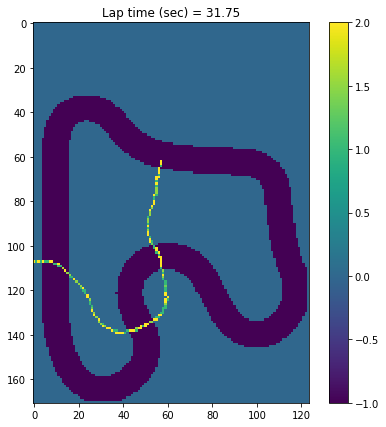

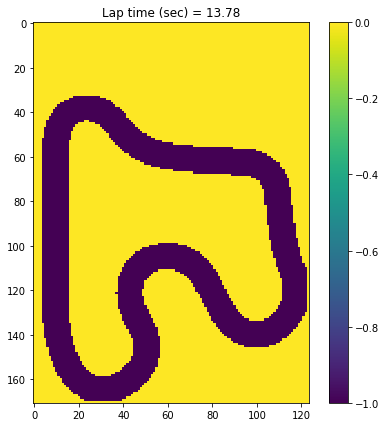

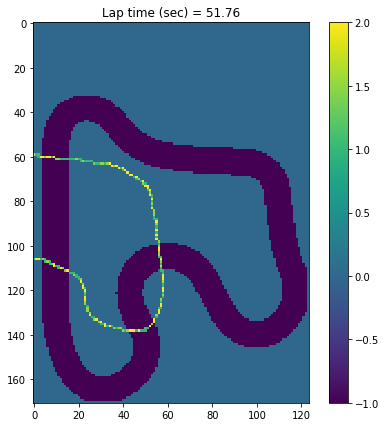

In [33]:
N_EPISODES = 3 
for e in range(66, 66+N_EPISODES):
    print ("Episode #%s " %e)
    episode_df = eval_df[eval_df['episode'] == e]
    plot_grid_world(episode_df, inner_border, outer_border, scale=5.0)
    print ("###############################################################\n\n")


## What is the model looking at?

Gradcam: visual heatmap of where the model is looking to make its decisions. based on https://arxiv.org/pdf/1610.02391.pdf

In [28]:
import cv2
import numpy as np
import tensorflow as tf

def visualize_gradcam_discrete_ppo(sess, rgb_img, category_index=0, num_of_actions=6):
    '''
    @inp: model session, RGB Image - np array, action_index, total number of actions 
    @return: overlayed heatmap
    '''
    
    img_arr = np.array(img)
    img_arr = rgb2gray(img_arr)
    img_arr = np.expand_dims(img_arr, axis=2)
    
    x = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/observation/observation:0')
    y = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    feed_dict = {x:[img_arr]}

    #Get he policy head for clipped ppo in coach
    model_out_layer = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    loss = tf.multiply(model_out_layer, tf.one_hot([category_index], num_of_actions))
    reduced_loss = tf.reduce_sum(loss[0])
    conv_output = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/observation/Conv2d_4/Conv2D:0')
    grads = tf.gradients(reduced_loss, conv_output)[0]
    output, grads_val = sess.run([conv_output, grads], feed_dict=feed_dict)
    weights = np.mean(grads_val, axis=(1, 2))
    cams = np.sum(weights * output, axis=3)

    ##im_h, im_w = 120, 160##
    im_h, im_w = rgb_img.shape[:2]

    cam = cams[0] #img 0
    image = np.uint8(rgb_img[:, :, ::-1] * 255.0) # RGB -> BGR
    cam = cv2.resize(cam, (im_w, im_h)) # zoom heatmap
    cam = np.maximum(cam, 0) # relu clip
    heatmap = cam / np.max(cam) # normalize
    cam = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET) # grayscale to color
    cam = np.float32(cam) + np.float32(image) # overlay heatmap
    cam = 255 * cam / (np.max(cam) + 1E-5) ##  Add expsilon for stability
    cam = np.uint8(cam)[:, :, ::-1] # to RGB

    return cam

In [29]:
import glob
img_path = "simulation_episode/"
all_files = sorted(glob.glob(img_path + '/*.png'))

In [33]:
model_path = GRAPH_PB_PATH + 'model_30.pb' #Change this to your model 'pb' frozen graph file

model, obs, model_out = load_session(model_path)
heatmaps = []
for f in all_files[:5]:
    img = np.array(Image.open(f))
    heatmap = visualize_gradcam_discrete_ppo(model, img, category_index=0, num_of_actions=10)
    heatmaps.append(heatmap)
tf.reset_default_graph()

load graph: intermediate_checkpoint/model_30.pb


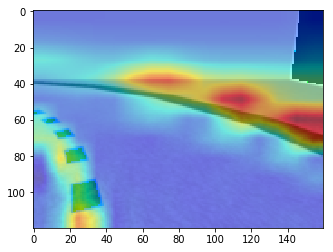

In [34]:
plt.imshow(heatmaps[0])